In [1]:
import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from PIL import Image
import seaborn as sns
from PIL import ImageOps
import torchvision.models as models

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")

In [3]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


Total Data containing Frontal and Lateral Xrays

In [4]:
# Paths to the files with training, and validation sets.
total_train_data = pd.read_csv('/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/train.csv')
print("Total data length:", len(total_train_data))

Total data length: 223414


Using Frontal Data only for Training and Testing 

In [5]:
data_frontal = total_train_data[total_train_data['Path'].str.contains("frontal")]  # use only frontal images
print("Total Frontal data length:", len(data_frontal))

Total Frontal data length: 191027


Data for test is 'Testdata'

In [6]:
Testdata = data_frontal.head(500)
Testdata.to_csv('/kaggle/working/test_mod.csv', index=False)
print("Test data length:", len(Testdata))

Test data length: 500


For Training using 'Train_data_frontal'

In [7]:
Train_data_frontal = data_frontal[500:]
Train_data_frontal.to_csv('/kaggle/working/train_mod.csv', index=False)
print("Train data length:", len(Train_data_frontal))

Train data length: 190527


In [8]:
Validdata = pd.read_csv('/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid.csv')
Validdata = Validdata[Validdata['Path'].str.contains("frontal")]  # use only frontal images
Validdata.to_csv('/kaggle/working/valid_mod.csv', index=False)
print("Valid data length:", len(Validdata))

Valid data length: 202


Path containing the fronta train, test, validation data frames

In [9]:
pathFileTrain = '/kaggle/working/train_mod.csv'
pathFileValid = '/kaggle/working/valid_mod.csv'
pathFileTest = '/kaggle/working/test_mod.csv'

In [10]:
print("Indices of Train data:", Train_data_frontal.index)
print("Indices of Test data:", Testdata.index)

Indices of Train data: Index([   621,    622,    623,    624,    625,    626,    627,    629,    630,
          632,
       ...
       223404, 223405, 223406, 223407, 223408, 223409, 223410, 223411, 223412,
       223413],
      dtype='int64', length=190527)
Indices of Test data: Index([  0,   1,   2,   4,   5,   7,   9,  10,  11,  12,
       ...
       611, 612, 613, 614, 615, 616, 617, 618, 619, 620],
      dtype='int64', length=500)


In [11]:
pathFileTrain_df = pd.read_csv(pathFileTrain)
pathFileTrain_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00147/study13...,Male,53,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,-1.0,NaN,1.0,NaN,1.0,1.0
1,CheXpert-v1.0-small/train/patient00147/study8/...,Male,53,Frontal,AP,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0
2,CheXpert-v1.0-small/train/patient00147/study14...,Male,53,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0
3,CheXpert-v1.0-small/train/patient00147/study10...,Male,53,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,-1.0,-1.0,-1.0,NaN,1.0,NaN,NaN,1.0
4,CheXpert-v1.0-small/train/patient00147/study9/...,Male,53,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0,NaN,1.0,1.0


In [12]:
pathFileTest_df = pd.read_csv(pathFileTest)
pathFileTest_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [13]:
len(pathFileTrain_df)

190527

In [14]:
len(pathFileTest_df)

500

In [15]:
num_classes=14
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Class Counts:
No Finding                     16924
Enlarged Cardiomediastinum     34725
Cardiomegaly                   37879
Lung Opacity                  103420
Lung Lesion                     8896
Edema                          77226
Consolidation                  56818
Pneumonia                      22491
Atelectasis                    60461
Pneumothorax                   68032
Pleural Effusion              111461
Pleural Other                   4509
Fracture                        9893
Support Devices               113135
dtype: int64


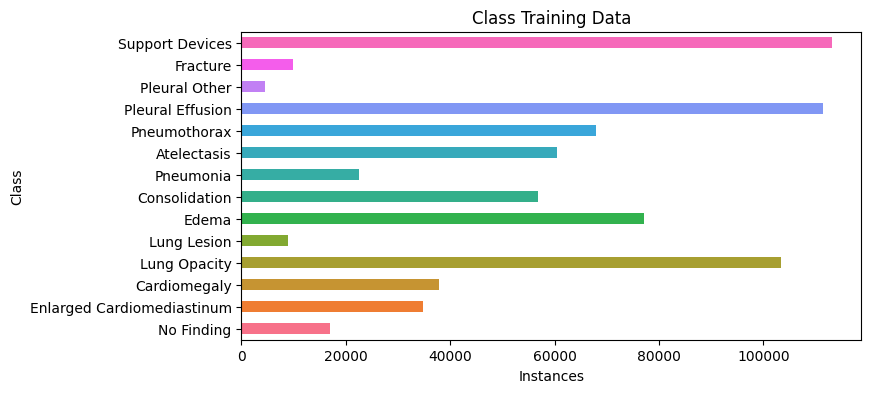

In [16]:
class_counts = pathFileTrain_df[class_names].count()
print("Class Counts:")
print(class_counts)
plt.figure(figsize=(8, 4))
colors = sns.color_palette("husl", len(class_counts))
class_counts.plot(kind='barh', color=colors)
plt.ylabel('Class')
plt.xlabel('Instances')
plt.title('Class Training Data')
plt.show()

In [17]:
num_classes = 14  # dimension of the output and number of classes
# Training settings: batch size, 
batch_size = 64
num_epochs =3# its also num of epochs ,maximum number of epochs
fraction = 1.0
com_round =7# communication rounds


In [18]:
from torchvision import transforms

# ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),  # RandomResizedCrop directly from original size
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=15),
        
        #transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Random Gaussian Blur
    ], p=0.7),  # Adjust the probability as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [19]:
class CheXpertDataSet(Dataset): # creating dataset  using  data_path which is path of dataset
    def __init__(self, data_PATH, transform=None , policy="ones"):
        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)  # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]

                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0

                image_names.append('/kaggle/input/chexpert-v10-small/' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform=transform
                                            

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = Image.open(image_name)

        # Check the number of channels in the image
        if image.mode != 'RGB':
            # Convert grayscale to RGB
            image = image.convert('RGB')

        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, torch.FloatTensor(label)


    def __len__(self):
        return len(self.image_names)

    def compute_class_counts(self):
        # Count occurrences of each class in the dataset
        class_counts = np.sum(np.array(self.labels), axis=0)
        return class_counts

In [20]:
# Load dataset
datasetTrain = CheXpertDataSet(pathFileTrain,transform, policy = "ones")
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid,val_transform)
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest,val_transform, policy = "ones")
print("Test data length:", len(datasetTest))

Train data length: 190527
Valid data length: 202
Test data length: 500


In [21]:

print("Train data length:", len(datasetTrain))

print("Valid data length:", len(datasetValid))

print("Test data length:", len(datasetTest))

Train data length: 190527
Valid data length: 202
Test data length: 500


Image Size: (224, 224, 3)
Number of Channels: 3


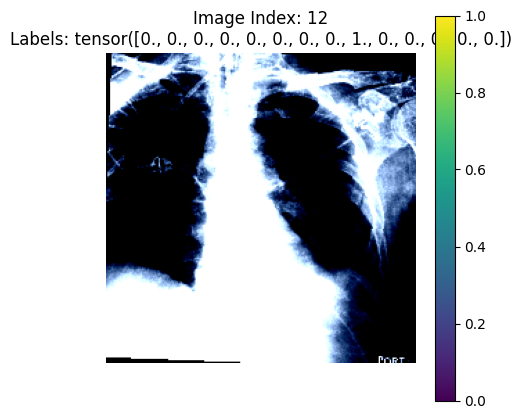

In [22]:
# index of the image
image_index = 12

# Getting the images and labels from the dataset
image, label = datasetTrain[image_index]
image_np = image.numpy().transpose((1, 2, 0))

# Display size and channels
print(f"Image Size: {image_np.shape}")
print(f"Number of Channels: {image_np.shape[2]}")

# Increase the display size
plt.figure(figsize=(5, 5))

# Display the image
plt.imshow(image_np)
cbar = plt.colorbar()
plt.title(f"Image Index: {image_index}\nLabels: {label}")
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.axis('off')
plt.show()

In [23]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=baf435f348bd4a635612396987fcc71ff70fb5a7f9cba09edcb52b872912fe81
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.metrics import accuracy_score, f1_score

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the HardSwish activation function
class HardSwish(nn.Module):
    def __init__(self):
        super(HardSwish, self).__init__()

    def forward(self, x):
        return x * (torch.clamp(x + 3, 0, 6) / 6)

# Define the model class
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b3')
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            HardSwish(),
            nn.Dropout(p=0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Load the model
model = CustomEfficientNet(num_classes).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 292MB/s]


Loaded pretrained weights for efficientnet-b3


In [25]:
checkpoint_path = '/kaggle/working/checkpoint.pth.tar'

# Save the model to the specified checkpoint path
torch.save(model.state_dict(), checkpoint_path)

print("Saving checkpoint to:", checkpoint_path)

Saving checkpoint to: /kaggle/working/checkpoint.pth.tar


In [26]:
lr = 0.001  # Initial learning rate
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-06)
# Initialize the scheduler with an initial learning rate
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', patience=20, factor=0.5, verbose=True)

In [27]:
import numpy as np
from torch.utils.data import Subset
# num_clients is the number of clients
num_clients = 10
# Shuffle the indices of the dataset
indices = np.random.permutation(len(datasetTrain))
# Calculate the length of each split
split_length = len(indices) // num_clients
# Create non-overlapping subsets
datasetTrain_1 = Subset(datasetTrain, indices[:split_length])
datasetTrain_2 = Subset(datasetTrain, indices[split_length:2*split_length])
datasetTrain_3 = Subset(datasetTrain, indices[2*split_length:3*split_length])
datasetTrain_4 = Subset(datasetTrain, indices[3*split_length:4*split_length])
datasetTrain_5 = Subset(datasetTrain, indices[4*split_length:5*split_length])
datasetTrain_6 = Subset(datasetTrain, indices[5*split_length:6*split_length])
datasetTrain_7 = Subset(datasetTrain, indices[6*split_length:7*split_length])
datasetTrain_8 = Subset(datasetTrain, indices[7*split_length:8*split_length])
datasetTrain_9 = Subset(datasetTrain, indices[8*split_length:9*split_length])
datasetTrain_10 = Subset(datasetTrain, indices[9*split_length:])
# Print the lengths of each split
print("Length of datasetTrain_1:", len(datasetTrain_1))
print("Length of datasetTrain_2:", len(datasetTrain_2))
print("Length of datasetTrain_3:", len(datasetTrain_3))
print("Length of datasetTrain_4:", len(datasetTrain_4))
print("Length of datasetTrain_5:", len(datasetTrain_5))
print("Length of datasetTrain_6:", len(datasetTrain_6))
print("Length of datasetTrain_7:", len(datasetTrain_7))
print("Length of datasetTrain_8:", len(datasetTrain_8))
print("Length of datasetTrain_9:", len(datasetTrain_9))
print("Length of datasetTrain_10:", len(datasetTrain_10))

Length of datasetTrain_1: 19052
Length of datasetTrain_2: 19052
Length of datasetTrain_3: 19052
Length of datasetTrain_4: 19052
Length of datasetTrain_5: 19052
Length of datasetTrain_6: 19052
Length of datasetTrain_7: 19052
Length of datasetTrain_8: 19052
Length of datasetTrain_9: 19052
Length of datasetTrain_10: 19059


In [28]:
# Define 5 DataLoaders
dataLoaderTrain_1 = DataLoader( datasetTrain_1, batch_size,
                               shuffle = True, num_workers = 4, pin_memory = True)
dataLoaderTrain_2 = DataLoader( datasetTrain_2, batch_size,
                               shuffle = True, num_workers = 4, pin_memory = True)
dataLoaderTrain_3 = DataLoader(datasetTrain_3, batch_size,
                               shuffle = True, num_workers = 4, pin_memory = True)
dataLoaderTrain_4 = DataLoader(datasetTrain_4, batch_size,
                               shuffle = True, num_workers = 4, pin_memory = True)
dataLoaderTrain_5 = DataLoader(datasetTrain_5, batch_size,
                               shuffle = True, num_workers = 4, pin_memory = True)
dataLoaderTrain_6 = DataLoader(datasetTrain_6, batch_size,
                             shuffle=True, num_workers=4, pin_memory=True)
dataLoaderTrain_7 = DataLoader(datasetTrain_7, batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
dataLoaderTrain_8 = DataLoader(datasetTrain_8, batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
dataLoaderTrain_9 = DataLoader(datasetTrain_9, batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
dataLoaderTrain_10 = DataLoader(datasetTrain_10, batch_size,
                                shuffle=True, num_workers=4, pin_memory=True)

In [29]:
# Define Valid and Test DataLoaders
dataLoaderVal = DataLoader(datasetValid,batch_size,shuffle = True, num_workers = 4, pin_memory = True)
dataLoaderTest = DataLoader(datasetTest,batch_size,shuffle = True, num_workers = 4, pin_memory = True)

In [30]:
#dT is assigned to dataset train of all clients from 1 to 5 
dT = [datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5, datasetTrain_6, datasetTrain_7, datasetTrain_8, datasetTrain_9, datasetTrain_10]
#dLT is assigned to dataset loader train of all clients from 1 to 5 
dLT = [dataLoaderTrain_1, dataLoaderTrain_2, dataLoaderTrain_3, dataLoaderTrain_4, dataLoaderTrain_5, dataLoaderTrain_6, dataLoaderTrain_7, dataLoaderTrain_8, dataLoaderTrain_9, dataLoaderTrain_10]

In [31]:
import torch
import time
from sklearn.metrics import roc_auc_score

class CheXpertTrainer():
    def __init__(self, model, optimizer, loss, use_gpu=True):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.use_gpu = use_gpu
        self.scheduler_plateau = None
        self.loss_train = 0  # Initialize training loss
        self.epoch = 0
        if use_gpu:
            self.model = self.model.cuda()

    def initialize(self, scheduler_plateau=None):
        self.scheduler_plateau = scheduler_plateau

    def train(self, dataLoaderTrain, dataLoaderVal,num_classes,num_epochs, checkpoint_path):
        if self.model is None or self.optimizer is None or self.loss is None:
            raise ValueError("Model, optimizer, and loss must be initialized before training.")

        loss_MIN = float('inf')
        train_start = []
        train_end = []

        for epochID in range(self.epoch, self.epoch + num_epochs):
            total_loss = 0.0  # Reseting the total loss at the beginning of each epoch
            print(f"Client {sel_clients[j] + 1} training for epoch {epochID + 1}")
            train_start.append(time.time())

            losst = self.epochTrain(dataLoaderTrain,num_classes)

            train_end.append(time.time())
            lossv = self.epochVal(dataLoaderVal,num_classes)
            print("Training loss: {:.3f}, Valid loss: {:.3f}".format(losst, lossv))

            if self.scheduler_plateau is not None:
                # Useing the scheduler after each epoch for learning rate updation
                self.scheduler_plateau.step(lossv)
                print("Current learning rate: {:.6f}".format(self.optimizer.param_groups[0]['lr']))

            if lossv < loss_MIN:
                loss_MIN = lossv
                print("Saving checkpoint to:", checkpoint_path)
                torch.save({'epoch': epochID + 1, 'state_dict': self.model.state_dict(),
                            'best_loss': loss_MIN, 'optimizer': self.optimizer.state_dict()},
                           checkpoint_path)
                print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(lossv))
            else:
                print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(lossv))

        
        train_time = np.array(train_end) - np.array(train_start)
        print("Training time for each epoch: {} seconds".format(train_time.round(0)))
        params = self.model.state_dict()
        return params

    def epochTrain(self, dataLoaderTrain,num_classes):
        self.model.train()
        self.loss_train = 0  
        losstrain = 0

        for batchID, (varInput, target) in enumerate(tqdm(dataLoaderTrain)):
            varInput = varInput.cuda() if self.use_gpu else varInput
            target = target.cuda() if self.use_gpu else target
            varOutput = self.model(varInput)
            lossvalue = self.loss(varOutput, target)

            self.optimizer.zero_grad()
            lossvalue.backward()
            self.optimizer.step()

            losstrain += lossvalue.item()

        return losstrain / len(dataLoaderTrain)
    
    def get_train_loss(self):
        return self.loss_train  # Return the accumulated training loss
    
    def epochVal(self, dataLoaderVal,num_classes):
        self.model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(tqdm(dataLoaderVal)):
                varInput = varInput.cuda() if self.use_gpu else varInput
                target = target.cuda() if self.use_gpu else target
                varOutput = self.model(varInput)

                lossVal += self.loss(varOutput, target)

        return lossVal / len(dataLoaderVal)

    def computeAUROC(self, dataGT, dataPRED,num_classes):
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()

        for i in range(num_classes):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC

    def epochTest(self, dataLoaderTest, num_classes):
        self.model.eval()
        lossTest = 0

        if self.use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()

        with torch.no_grad():
            for i, (input, target) in enumerate(tqdm(dataLoaderTest)):
                target = target.cuda() if self.use_gpu else target  
                outGT = torch.cat((outGT, target), 0)

                if self.use_gpu:
                    input = input.cuda()
                    target = target.cuda(non_blocking=True)
                else:
                    input = input

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
                varInput = varInput.cuda() if self.use_gpu else varInput

                out = self.model(varInput)
                outPRED = torch.cat((outPRED, out), 0)

                lossTest += self.loss(out, target)

        aurocIndividual = self.computeAUROC(outGT, outPRED,num_classes)
        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean ', aurocMean)

        for i in range(0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])

        return outGT, outPRED, lossTest / len(dataLoaderTest)
    
    

In [32]:

loss=nn.BCEWithLogitsLoss()

In [33]:
# Initializing the trainer
trainer = CheXpertTrainer(model, optimizer, loss)
trainer.initialize(scheduler_plateau)

# Training loop
best_loss = float('inf')  # Initialize best_loss to positive infinity

for i in range(com_round):
    print("[[[ Communication Round {} Start ]]]".format(i + 1))
    params = [{} for _ in range(len(dLT))] 
    print(f'Epoch {trainer.epoch + 1}, Learning Rate: {optimizer.param_groups[0]["lr"]}')
    sel_clients = sorted(random.sample(range(num_clients), round(num_clients * fraction)))
    print("The number of clients:", len(sel_clients))

    total_train_loss = 0.0

    for j in range(len(sel_clients)):
        train_valid_start = time.time()
        params[sel_clients[j]] = trainer.train(dLT[sel_clients[j]], dataLoaderVal,num_classes, num_epochs, checkpoint_path)
        total_train_loss += trainer.get_train_loss()
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)

    # Weighted averaging step
    fidx = [idx for idx in range(len(params)) if params[idx] is not None][0]
    lidx = [idx for idx in range(len(params)) if params[idx] is not None][-1]
    for key in params[fidx]:  # Step 4: return updates to server
        weights, weightn = [], []
        for k in sel_clients:
            weights.append(params[k][key] * len(dLT[k]))
            weightn.append(len(dLT[k]))
        params[lidx][key] = sum(weights) / sum(weightn)  # weighted averaging model weights

    # Print message for indicating the update
    before_update = {key: val.cpu().numpy() for key, val in model.state_dict().items()}
    model.load_state_dict(params[lidx])
    after_update = {key: val.cpu().numpy() for key, val in model.state_dict().items()}

    # Checking,  if the parameters were really  updated
    if any(np.any(before_update[key] != after_update[key]) for key in before_update):
        print(f"[Round {i + 1}] Global Model Parameters Updated with Federated Averaging")
    else:
        print(f"[Round {i + 1}] Global Model Parameters Unchanged")

    # Update the global model with the weighted average
    model.load_state_dict(params[lidx])

    # Save the global model
    torch.save({'state_dict': model.state_dict()}, 'Round' + str(i + 1) + '_global_model.pth.tar')
    print("[[[ Round {} End and model saved ]]]".format(i + 1))

    # Print the training loss for the epoch
    train_loss = total_train_loss / len(sel_clients)
    print("Epoch {}: Training Loss: {:.4f}".format(trainer.epoch + 1, train_loss))

    # Step the trainer (e.g., update epoch count, scheduler, etc.)
    #trainer.step()

# Final steps after all communication rounds
print("Global model trained")

# Check if the parameters of the final global model were updated
before_final_update = {key: val.cpu().numpy() for key, val in model.state_dict().items()}
model.load_state_dict(params[lidx])
after_final_update = {key: val.cpu().numpy() for key, val in model.state_dict().items()}

# Check if the parameters were updated
if any(np.any(before_final_update[key] != after_final_update[key]) for key in before_final_update):
    print("Final Global Model Parameters Updated")
else:
    print("Final Global Model Parameters Unchanged")

# Save the final global model
torch.save({'state_dict': model.state_dict()}, 'Final_global_model.pth.tar')
print("Final model saved")

[[[ Communication Round 1 Start ]]]
Epoch 1, Learning Rate: 0.001
The number of clients: 10
Client 1 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Training loss: 0.411, Valid loss: 0.441
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.4407, device='cuda:0')
Client 1 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Training loss: 0.393, Valid loss: 0.399
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3987, device='cuda:0')
Client 1 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Training loss: 0.388, Valid loss: 0.423
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.4232, device='cuda:0')
Training time for each epoch: [159. 157. 156.] seconds
Client 2 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Training loss: 0.387, Valid loss: 0.393
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3928, device='cuda:0')
Client 2 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Training loss: 0.383, Valid loss: 0.414
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.4141, device='cuda:0')
Client 2 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Training loss: 0.381, Valid loss: 0.393
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3929, device='cuda:0')
Training time for each epoch: [157. 157. 156.] seconds
Client 3 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


Training loss: 0.380, Valid loss: 0.394
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3941, device='cuda:0')
Client 3 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Training loss: 0.378, Valid loss: 0.383
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3828, device='cuda:0')
Client 3 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Training loss: 0.376, Valid loss: 0.390
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3897, device='cuda:0')
Training time for each epoch: [157. 156. 157.] seconds
Client 4 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Training loss: 0.375, Valid loss: 0.373
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3733, device='cuda:0')
Client 4 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Training loss: 0.373, Valid loss: 0.399
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3986, device='cuda:0')
Client 4 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Training loss: 0.371, Valid loss: 0.358
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3579, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 5 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Training loss: 0.374, Valid loss: 0.407
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.4074, device='cuda:0')
Client 5 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Training loss: 0.373, Valid loss: 0.390
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3900, device='cuda:0')
Client 5 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.372, Valid loss: 0.411
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.4110, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 6 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Training loss: 0.373, Valid loss: 0.367
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3669, device='cuda:0')
Client 6 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Training loss: 0.372, Valid loss: 0.407
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.4068, device='cuda:0')
Client 6 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Training loss: 0.370, Valid loss: 0.374
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3740, device='cuda:0')
Training time for each epoch: [157. 157. 156.] seconds
Client 7 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Training loss: 0.372, Valid loss: 0.368
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3678, device='cuda:0')
Client 7 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Training loss: 0.370, Valid loss: 0.381
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3807, device='cuda:0')
Client 7 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Training loss: 0.368, Valid loss: 0.394
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3936, device='cuda:0')
Training time for each epoch: [157. 156. 157.] seconds
Client 8 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.370, Valid loss: 0.389
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3889, device='cuda:0')
Client 8 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Training loss: 0.367, Valid loss: 0.371
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3712, device='cuda:0')
Client 8 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.366, Valid loss: 0.360
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3604, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 9 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training loss: 0.368, Valid loss: 0.327
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3272, device='cuda:0')
Client 9 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Training loss: 0.366, Valid loss: 0.363
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3626, device='cuda:0')
Client 9 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.364, Valid loss: 0.351
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3509, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 10 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Training loss: 0.365, Valid loss: 0.339
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3393, device='cuda:0')
Client 10 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


Training loss: 0.364, Valid loss: 0.356
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3563, device='cuda:0')
Client 10 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Training loss: 0.362, Valid loss: 0.364
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3639, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
[Round 1] Global Model Parameters Updated with Federated Averaging
[[[ Round 1 End and model saved ]]]
Epoch 1: Training Loss: 0.0000
[[[ Communication Round 2 Start ]]]
Epoch 1, Learning Rate: 0.001
The number of clients: 10
Client 1 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training loss: 0.367, Valid loss: 0.380
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3804, device='cuda:0')
Client 1 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Training loss: 0.364, Valid loss: 0.379
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3789, device='cuda:0')
Client 1 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Training loss: 0.363, Valid loss: 0.387
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3867, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 2 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Training loss: 0.367, Valid loss: 0.362
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3621, device='cuda:0')
Client 2 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training loss: 0.364, Valid loss: 0.358
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3584, device='cuda:0')
Client 2 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Training loss: 0.364, Valid loss: 0.374
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3742, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 3 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Training loss: 0.366, Valid loss: 0.326
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3265, device='cuda:0')
Client 3 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training loss: 0.363, Valid loss: 0.389
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3890, device='cuda:0')
Client 3 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Training loss: 0.362, Valid loss: 0.380
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3802, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 4 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


Training loss: 0.361, Valid loss: 0.394
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3939, device='cuda:0')
Client 4 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


Training loss: 0.360, Valid loss: 0.354
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3539, device='cuda:0')
Client 4 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Training loss: 0.359, Valid loss: 0.362
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3619, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 5 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.364, Valid loss: 0.358
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3584, device='cuda:0')
Client 5 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Training loss: 0.361, Valid loss: 0.384
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3842, device='cuda:0')
Client 5 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.360, Valid loss: 0.380
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3798, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 6 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Training loss: 0.364, Valid loss: 0.387
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3866, device='cuda:0')
Client 6 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Training loss: 0.362, Valid loss: 0.370
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3696, device='cuda:0')
Client 6 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Training loss: 0.360, Valid loss: 0.382
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3820, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 7 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Training loss: 0.363, Valid loss: 0.369
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3694, device='cuda:0')
Client 7 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Training loss: 0.361, Valid loss: 0.384
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3842, device='cuda:0')
Client 7 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.359, Valid loss: 0.359
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3594, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 8 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training loss: 0.361, Valid loss: 0.359
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3594, device='cuda:0')
Client 8 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.360, Valid loss: 0.380
Current learning rate: 0.001000
Epoch 2 [----] loss = tensor(0.3795, device='cuda:0')
Client 8 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Training loss: 0.358, Valid loss: 0.381
Current learning rate: 0.001000
Epoch 3 [----] loss = tensor(0.3811, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 9 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.361, Valid loss: 0.368
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3685, device='cuda:0')
Client 9 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.358, Valid loss: 0.368
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3684, device='cuda:0')
Client 9 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training loss: 0.357, Valid loss: 0.327
Current learning rate: 0.001000
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3273, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 10 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Training loss: 0.359, Valid loss: 0.394
Epoch 00058: reducing learning rate of group 0 to 5.0000e-04.
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3936, device='cuda:0')
Client 10 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Training loss: 0.352, Valid loss: 0.332
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3323, device='cuda:0')
Client 10 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Training loss: 0.350, Valid loss: 0.351
Current learning rate: 0.000500
Epoch 3 [----] loss = tensor(0.3509, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
[Round 2] Global Model Parameters Updated with Federated Averaging
[[[ Round 2 End and model saved ]]]
Epoch 1: Training Loss: 0.0000
[[[ Communication Round 3 Start ]]]
Epoch 1, Learning Rate: 0.0005
The number of clients: 10
Client 1 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Training loss: 0.356, Valid loss: 0.381
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3809, device='cuda:0')
Client 1 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Training loss: 0.354, Valid loss: 0.336
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3365, device='cuda:0')
Client 1 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


Training loss: 0.352, Valid loss: 0.353
Current learning rate: 0.000500
Epoch 3 [----] loss = tensor(0.3535, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 2 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Training loss: 0.357, Valid loss: 0.361
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3609, device='cuda:0')
Client 2 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.355, Valid loss: 0.361
Current learning rate: 0.000500
Epoch 2 [----] loss = tensor(0.3612, device='cuda:0')
Client 2 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Training loss: 0.353, Valid loss: 0.364
Current learning rate: 0.000500
Epoch 3 [----] loss = tensor(0.3639, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 3 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Training loss: 0.355, Valid loss: 0.343
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3427, device='cuda:0')
Client 3 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Training loss: 0.353, Valid loss: 0.368
Current learning rate: 0.000500
Epoch 2 [----] loss = tensor(0.3683, device='cuda:0')
Client 3 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.351, Valid loss: 0.345
Current learning rate: 0.000500
Epoch 3 [----] loss = tensor(0.3447, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 4 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Training loss: 0.351, Valid loss: 0.383
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3831, device='cuda:0')
Client 4 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Training loss: 0.349, Valid loss: 0.369
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3690, device='cuda:0')
Client 4 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training loss: 0.347, Valid loss: 0.363
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3632, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 5 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.354, Valid loss: 0.367
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3670, device='cuda:0')
Client 5 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Training loss: 0.351, Valid loss: 0.359
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3594, device='cuda:0')
Client 5 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Training loss: 0.351, Valid loss: 0.383
Current learning rate: 0.000500
Epoch 3 [----] loss = tensor(0.3831, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 6 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.354, Valid loss: 0.353
Current learning rate: 0.000500
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3531, device='cuda:0')
Client 6 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Training loss: 0.352, Valid loss: 0.375
Current learning rate: 0.000500
Epoch 2 [----] loss = tensor(0.3750, device='cuda:0')
Client 6 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Training loss: 0.350, Valid loss: 0.368
Current learning rate: 0.000500
Epoch 3 [----] loss = tensor(0.3677, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 7 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Training loss: 0.352, Valid loss: 0.388
Epoch 00079: reducing learning rate of group 0 to 2.5000e-04.
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3882, device='cuda:0')
Client 7 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Training loss: 0.349, Valid loss: 0.354
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3545, device='cuda:0')
Client 7 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Training loss: 0.347, Valid loss: 0.380
Current learning rate: 0.000250
Epoch 3 [----] loss = tensor(0.3797, device='cuda:0')
Training time for each epoch: [157. 157. 156.] seconds
Client 8 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Training loss: 0.350, Valid loss: 0.346
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3460, device='cuda:0')
Client 8 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Training loss: 0.348, Valid loss: 0.378
Current learning rate: 0.000250
Epoch 2 [----] loss = tensor(0.3777, device='cuda:0')
Client 8 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.347, Valid loss: 0.364
Current learning rate: 0.000250
Epoch 3 [----] loss = tensor(0.3635, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 9 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.348, Valid loss: 0.383
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3828, device='cuda:0')
Client 9 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.346, Valid loss: 0.362
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3620, device='cuda:0')
Client 9 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training loss: 0.344, Valid loss: 0.376
Current learning rate: 0.000250
Epoch 3 [----] loss = tensor(0.3756, device='cuda:0')
Training time for each epoch: [157. 156. 157.] seconds
Client 10 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.347, Valid loss: 0.373
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3730, device='cuda:0')
Client 10 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Training loss: 0.346, Valid loss: 0.338
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3376, device='cuda:0')
Client 10 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Training loss: 0.343, Valid loss: 0.365
Current learning rate: 0.000250
Epoch 3 [----] loss = tensor(0.3652, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
[Round 3] Global Model Parameters Updated with Federated Averaging
[[[ Round 3 End and model saved ]]]
Epoch 1: Training Loss: 0.0000
[[[ Communication Round 4 Start ]]]
Epoch 1, Learning Rate: 0.00025
The number of clients: 10
Client 1 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


Training loss: 0.348, Valid loss: 0.348
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3479, device='cuda:0')
Client 1 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Training loss: 0.347, Valid loss: 0.346
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3457, device='cuda:0')
Client 1 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.346, Valid loss: 0.363
Current learning rate: 0.000250
Epoch 3 [----] loss = tensor(0.3630, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 2 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training loss: 0.350, Valid loss: 0.383
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3826, device='cuda:0')
Client 2 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Training loss: 0.348, Valid loss: 0.382
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3818, device='cuda:0')
Client 2 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


Training loss: 0.347, Valid loss: 0.350
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3504, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 3 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Training loss: 0.349, Valid loss: 0.356
Current learning rate: 0.000250
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3564, device='cuda:0')
Client 3 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.346, Valid loss: 0.368
Current learning rate: 0.000250
Epoch 2 [----] loss = tensor(0.3684, device='cuda:0')
Client 3 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Training loss: 0.345, Valid loss: 0.365
Current learning rate: 0.000250
Epoch 3 [----] loss = tensor(0.3653, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 4 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Training loss: 0.344, Valid loss: 0.335
Epoch 00100: reducing learning rate of group 0 to 1.2500e-04.
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3345, device='cuda:0')
Client 4 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Training loss: 0.341, Valid loss: 0.349
Current learning rate: 0.000125
Epoch 2 [----] loss = tensor(0.3487, device='cuda:0')
Client 4 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.341, Valid loss: 0.336
Current learning rate: 0.000125
Epoch 3 [----] loss = tensor(0.3365, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 5 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Training loss: 0.346, Valid loss: 0.365
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3645, device='cuda:0')
Client 5 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Training loss: 0.344, Valid loss: 0.355
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3551, device='cuda:0')
Client 5 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Training loss: 0.344, Valid loss: 0.340
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3395, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 6 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.346, Valid loss: 0.363
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3633, device='cuda:0')
Client 6 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Training loss: 0.345, Valid loss: 0.331
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3314, device='cuda:0')
Client 6 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Training loss: 0.344, Valid loss: 0.365
Current learning rate: 0.000125
Epoch 3 [----] loss = tensor(0.3653, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 7 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Training loss: 0.345, Valid loss: 0.336
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3355, device='cuda:0')
Client 7 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Training loss: 0.345, Valid loss: 0.384
Current learning rate: 0.000125
Epoch 2 [----] loss = tensor(0.3843, device='cuda:0')
Client 7 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Training loss: 0.344, Valid loss: 0.335
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3351, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 8 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.345, Valid loss: 0.383
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3831, device='cuda:0')
Client 8 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Training loss: 0.344, Valid loss: 0.355
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3547, device='cuda:0')
Client 8 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.343, Valid loss: 0.380
Current learning rate: 0.000125
Epoch 3 [----] loss = tensor(0.3799, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 9 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


Training loss: 0.344, Valid loss: 0.384
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3839, device='cuda:0')
Client 9 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.342, Valid loss: 0.355
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3547, device='cuda:0')
Client 9 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Training loss: 0.341, Valid loss: 0.369
Current learning rate: 0.000125
Epoch 3 [----] loss = tensor(0.3690, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 10 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Training loss: 0.343, Valid loss: 0.358
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3575, device='cuda:0')
Client 10 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.341, Valid loss: 0.352
Current learning rate: 0.000125
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3520, device='cuda:0')
Client 10 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Training loss: 0.341, Valid loss: 0.386
Current learning rate: 0.000125
Epoch 3 [----] loss = tensor(0.3861, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
[Round 4] Global Model Parameters Updated with Federated Averaging
[[[ Round 4 End and model saved ]]]
Epoch 1: Training Loss: 0.0000
[[[ Communication Round 5 Start ]]]
Epoch 1, Learning Rate: 0.000125
The number of clients: 10
Client 1 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


Training loss: 0.346, Valid loss: 0.371
Epoch 00121: reducing learning rate of group 0 to 6.2500e-05.
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3711, device='cuda:0')
Client 1 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


Training loss: 0.343, Valid loss: 0.356
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3558, device='cuda:0')
Client 1 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training loss: 0.342, Valid loss: 0.349
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3485, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 2 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Training loss: 0.345, Valid loss: 0.335
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3347, device='cuda:0')
Client 2 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Training loss: 0.345, Valid loss: 0.367
Current learning rate: 0.000063
Epoch 2 [----] loss = tensor(0.3668, device='cuda:0')
Client 2 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.343, Valid loss: 0.359
Current learning rate: 0.000063
Epoch 3 [----] loss = tensor(0.3594, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 3 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Training loss: 0.343, Valid loss: 0.397
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3974, device='cuda:0')
Client 3 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.343, Valid loss: 0.378
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3780, device='cuda:0')
Client 3 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Training loss: 0.342, Valid loss: 0.353
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3525, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 4 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.340, Valid loss: 0.352
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3524, device='cuda:0')
Client 4 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Training loss: 0.338, Valid loss: 0.349
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3495, device='cuda:0')
Client 4 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.339, Valid loss: 0.384
Current learning rate: 0.000063
Epoch 3 [----] loss = tensor(0.3838, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 5 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Training loss: 0.344, Valid loss: 0.387
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3871, device='cuda:0')
Client 5 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Training loss: 0.343, Valid loss: 0.367
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3667, device='cuda:0')
Client 5 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.342, Valid loss: 0.376
Current learning rate: 0.000063
Epoch 3 [----] loss = tensor(0.3765, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 6 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


Training loss: 0.344, Valid loss: 0.366
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3664, device='cuda:0')
Client 6 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Training loss: 0.342, Valid loss: 0.338
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3377, device='cuda:0')
Client 6 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


Training loss: 0.343, Valid loss: 0.356
Current learning rate: 0.000063
Epoch 3 [----] loss = tensor(0.3560, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 7 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Training loss: 0.342, Valid loss: 0.378
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3785, device='cuda:0')
Client 7 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Training loss: 0.341, Valid loss: 0.349
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3488, device='cuda:0')
Client 7 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


Training loss: 0.342, Valid loss: 0.341
Current learning rate: 0.000063
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3411, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 8 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Training loss: 0.343, Valid loss: 0.358
Epoch 00142: reducing learning rate of group 0 to 3.1250e-05.
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3579, device='cuda:0')
Client 8 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Training loss: 0.341, Valid loss: 0.327
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3270, device='cuda:0')
Client 8 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Training loss: 0.342, Valid loss: 0.376
Current learning rate: 0.000031
Epoch 3 [----] loss = tensor(0.3756, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 9 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Training loss: 0.341, Valid loss: 0.376
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3762, device='cuda:0')
Client 9 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Training loss: 0.339, Valid loss: 0.358
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3580, device='cuda:0')
Client 9 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.340, Valid loss: 0.363
Current learning rate: 0.000031
Epoch 3 [----] loss = tensor(0.3627, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 10 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Training loss: 0.339, Valid loss: 0.337
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3375, device='cuda:0')
Client 10 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Training loss: 0.340, Valid loss: 0.358
Current learning rate: 0.000031
Epoch 2 [----] loss = tensor(0.3584, device='cuda:0')
Client 10 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.339, Valid loss: 0.354
Current learning rate: 0.000031
Epoch 3 [----] loss = tensor(0.3539, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
[Round 5] Global Model Parameters Updated with Federated Averaging
[[[ Round 5 End and model saved ]]]
Epoch 1: Training Loss: 0.0000
[[[ Communication Round 6 Start ]]]
Epoch 1, Learning Rate: 3.125e-05
The number of clients: 10
Client 1 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


Training loss: 0.343, Valid loss: 0.384
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3836, device='cuda:0')
Client 1 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.342, Valid loss: 0.347
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3475, device='cuda:0')
Client 1 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Training loss: 0.342, Valid loss: 0.349
Current learning rate: 0.000031
Epoch 3 [----] loss = tensor(0.3487, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 2 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


Training loss: 0.343, Valid loss: 0.328
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3282, device='cuda:0')
Client 2 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training loss: 0.343, Valid loss: 0.359
Current learning rate: 0.000031
Epoch 2 [----] loss = tensor(0.3592, device='cuda:0')
Client 2 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training loss: 0.342, Valid loss: 0.367
Current learning rate: 0.000031
Epoch 3 [----] loss = tensor(0.3674, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 3 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.342, Valid loss: 0.373
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3726, device='cuda:0')
Client 3 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Training loss: 0.341, Valid loss: 0.396
Current learning rate: 0.000031
Epoch 2 [----] loss = tensor(0.3958, device='cuda:0')
Client 3 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.341, Valid loss: 0.372
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3715, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 4 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Training loss: 0.337, Valid loss: 0.384
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3841, device='cuda:0')
Client 4 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.338, Valid loss: 0.352
Current learning rate: 0.000031
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3521, device='cuda:0')
Client 4 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Training loss: 0.338, Valid loss: 0.380
Current learning rate: 0.000031
Epoch 3 [----] loss = tensor(0.3797, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 5 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Training loss: 0.341, Valid loss: 0.371
Epoch 00163: reducing learning rate of group 0 to 1.5625e-05.
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3710, device='cuda:0')
Client 5 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Training loss: 0.341, Valid loss: 0.380
Current learning rate: 0.000016
Epoch 2 [----] loss = tensor(0.3801, device='cuda:0')
Client 5 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Training loss: 0.341, Valid loss: 0.376
Current learning rate: 0.000016
Epoch 3 [----] loss = tensor(0.3758, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 6 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Training loss: 0.343, Valid loss: 0.381
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3809, device='cuda:0')
Client 6 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Training loss: 0.342, Valid loss: 0.359
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3586, device='cuda:0')
Client 6 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.341, Valid loss: 0.378
Current learning rate: 0.000016
Epoch 3 [----] loss = tensor(0.3784, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 7 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Training loss: 0.340, Valid loss: 0.375
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3747, device='cuda:0')
Client 7 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Training loss: 0.341, Valid loss: 0.375
Current learning rate: 0.000016
Epoch 2 [----] loss = tensor(0.3749, device='cuda:0')
Client 7 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training loss: 0.340, Valid loss: 0.369
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3694, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 8 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Training loss: 0.341, Valid loss: 0.377
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3772, device='cuda:0')
Client 8 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training loss: 0.341, Valid loss: 0.394
Current learning rate: 0.000016
Epoch 2 [----] loss = tensor(0.3943, device='cuda:0')
Client 8 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Training loss: 0.341, Valid loss: 0.351
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3512, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 9 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Training loss: 0.339, Valid loss: 0.365
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3653, device='cuda:0')
Client 9 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Training loss: 0.340, Valid loss: 0.380
Current learning rate: 0.000016
Epoch 2 [----] loss = tensor(0.3798, device='cuda:0')
Client 9 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training loss: 0.340, Valid loss: 0.335
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3353, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 10 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Training loss: 0.339, Valid loss: 0.351
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3508, device='cuda:0')
Client 10 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Training loss: 0.338, Valid loss: 0.359
Current learning rate: 0.000016
Epoch 2 [----] loss = tensor(0.3592, device='cuda:0')
Client 10 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Training loss: 0.337, Valid loss: 0.341
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3414, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
[Round 6] Global Model Parameters Updated with Federated Averaging
[[[ Round 6 End and model saved ]]]
Epoch 1: Training Loss: 0.0000
[[[ Communication Round 7 Start ]]]
Epoch 1, Learning Rate: 1.5625e-05
The number of clients: 10
Client 1 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.342, Valid loss: 0.388
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3882, device='cuda:0')
Client 1 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Training loss: 0.341, Valid loss: 0.360
Current learning rate: 0.000016
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3597, device='cuda:0')
Client 1 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Training loss: 0.340, Valid loss: 0.376
Current learning rate: 0.000016
Epoch 3 [----] loss = tensor(0.3762, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 2 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


Training loss: 0.343, Valid loss: 0.362
Epoch 00184: reducing learning rate of group 0 to 7.8125e-06.
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3616, device='cuda:0')
Client 2 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


Training loss: 0.342, Valid loss: 0.361
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3609, device='cuda:0')
Client 2 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


Training loss: 0.341, Valid loss: 0.349
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3486, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 3 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


Training loss: 0.341, Valid loss: 0.382
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3818, device='cuda:0')
Client 3 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Training loss: 0.341, Valid loss: 0.393
Current learning rate: 0.000008
Epoch 2 [----] loss = tensor(0.3926, device='cuda:0')
Client 3 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


Training loss: 0.341, Valid loss: 0.338
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3376, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 4 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Training loss: 0.338, Valid loss: 0.350
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3495, device='cuda:0')
Client 4 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.338, Valid loss: 0.376
Current learning rate: 0.000008
Epoch 2 [----] loss = tensor(0.3756, device='cuda:0')
Client 4 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Training loss: 0.336, Valid loss: 0.365
Current learning rate: 0.000008
Epoch 3 [----] loss = tensor(0.3646, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 5 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Training loss: 0.341, Valid loss: 0.357
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3570, device='cuda:0')
Client 5 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


Training loss: 0.342, Valid loss: 0.353
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3533, device='cuda:0')
Client 5 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


Training loss: 0.340, Valid loss: 0.340
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3396, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 6 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Training loss: 0.341, Valid loss: 0.324
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3244, device='cuda:0')
Client 6 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Training loss: 0.342, Valid loss: 0.360
Current learning rate: 0.000008
Epoch 2 [----] loss = tensor(0.3604, device='cuda:0')
Client 6 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training loss: 0.342, Valid loss: 0.354
Current learning rate: 0.000008
Epoch 3 [----] loss = tensor(0.3542, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 7 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.341, Valid loss: 0.349
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3492, device='cuda:0')
Client 7 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training loss: 0.341, Valid loss: 0.338
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3382, device='cuda:0')
Client 7 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


Training loss: 0.340, Valid loss: 0.346
Current learning rate: 0.000008
Epoch 3 [----] loss = tensor(0.3456, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 8 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Training loss: 0.341, Valid loss: 0.353
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3530, device='cuda:0')
Client 8 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Training loss: 0.340, Valid loss: 0.393
Current learning rate: 0.000008
Epoch 2 [----] loss = tensor(0.3927, device='cuda:0')
Client 8 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Training loss: 0.340, Valid loss: 0.353
Current learning rate: 0.000008
Epoch 3 [----] loss = tensor(0.3530, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 9 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Training loss: 0.340, Valid loss: 0.383
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3832, device='cuda:0')
Client 9 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


Training loss: 0.339, Valid loss: 0.373
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 2 [save] loss = tensor(0.3729, device='cuda:0')
Client 9 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Training loss: 0.338, Valid loss: 0.369
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3688, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
Client 10 training for epoch 1


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


Training loss: 0.338, Valid loss: 0.349
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 1 [save] loss = tensor(0.3486, device='cuda:0')
Client 10 training for epoch 2


100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


Training loss: 0.338, Valid loss: 0.353
Current learning rate: 0.000008
Epoch 2 [----] loss = tensor(0.3533, device='cuda:0')
Client 10 training for epoch 3


100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


Training loss: 0.338, Valid loss: 0.348
Current learning rate: 0.000008
Saving checkpoint to: /kaggle/working/checkpoint.pth.tar
Epoch 3 [save] loss = tensor(0.3475, device='cuda:0')
Training time for each epoch: [157. 157. 157.] seconds
[Round 7] Global Model Parameters Updated with Federated Averaging
[[[ Round 7 End and model saved ]]]
Epoch 1: Training Loss: 0.0000
Global model trained
Final Global Model Parameters Unchanged
Final model saved


In [35]:
# Load the final global model checkpoint
final_checkpoint_path = 'Final_global_model.pth.tar'
if os.path.exists(final_checkpoint_path):
    try:
        checkpoint_data = torch.load(final_checkpoint_path)
        model.load_state_dict(checkpoint_data['state_dict'])
        print("Final global model loaded successfully.")
    except Exception as e:
        print("Error loading final global model checkpoint:", e)
else:
    print("Final global model checkpoint not found. Please make sure it exists.")
# outGT is ground truth and outPRED is the prediction
outGT, outPRED, final_loss = trainer.epochTest(dataLoaderTest,num_classes)

Final global model loaded successfully.


100%|██████████| 8/8 [00:03<00:00,  2.67it/s]

AUROC mean  0.802716778854317
No Finding   0.9066222222222222
Enlarged Cardiomediastinum   0.6208791208791209
Cardiomegaly   0.834685598377282
Lung Opacity   0.7259778503296843
Lung Lesion   0.8377263157894738
Edema   0.846648495085995
Consolidation   0.752925
Pneumonia   0.7532543342478548
Atelectasis   0.6978715870642851
Pneumothorax   0.8539347975967694
Pleural Effusion   0.8939554103401883
Pleural Other   0.7822830578512396
Fracture   0.8391223605474929
Support Devices   0.8921487536288295


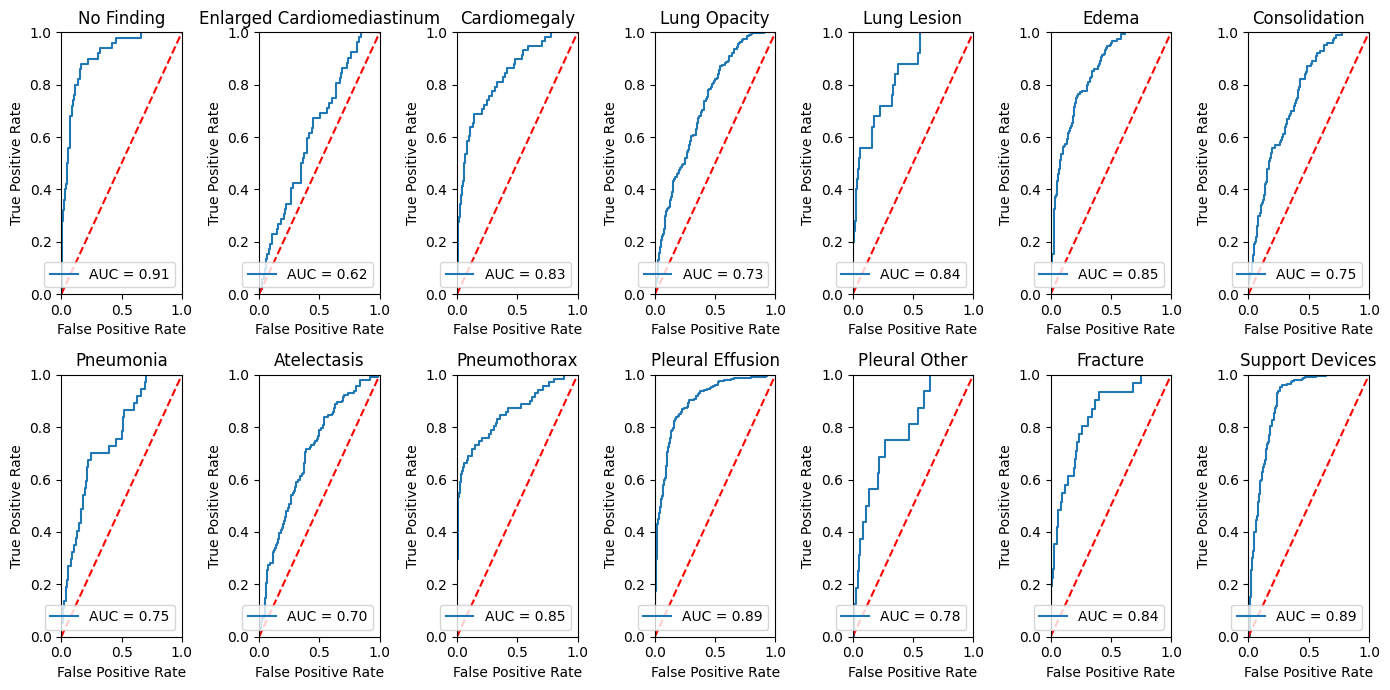

In [37]:
fig, axes = plt.subplots(2, 7, figsize=(14, 7))
for i in range(num_classes):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:, i], outPRED.cpu()[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    row = i // 7
    col = i % 7
    ax = axes[row, col]
    ax.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(class_names[i])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
fig.tight_layout()
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (3, 1)
plt.savefig('/kaggle/working/ROC.png', dpi = 1000)
plt.show()